In [1]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import statsmodels.api as sm


import warnings
warnings.filterwarnings("ignore")

<h3> Load Dataset </h3>

In [2]:
data = pd.read_csv('datasets/UMCSENT_PCE.csv', index_col=0, infer_datetime_format=True, parse_dates=['DATE'])

In [3]:
data.head()

,UMCSENT,UMCSENT_CHG,PCE,PCE_CHG
DATE,,,,
1978-01-01,83.7,0.000000,1336.0,0.000000
1978-02-01,84.3,0.007168,1329.5,-0.004865
1978-03-01,78.8,-0.065243,1355.1,0.019255
1978-04-01,81.6,0.035533,1377.5,0.016530
1978-05-01,82.9,0.015931,1396.4,0.013721


<h3> Plot Dataset </h3>

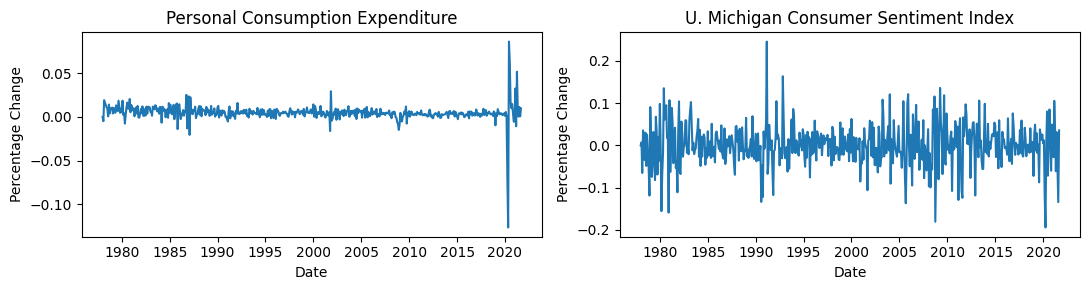

In [4]:
fig, axes = plt.subplots(1, 2, figsize=(11,3))

# Plot 'Personal Consumption Expenditure' 
axes[0].plot(data['PCE_CHG'])
axes[0].set_title('Personal Consumption Expenditure')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Percentage Change')

# Plot 'U. Michigan Consumer Sentiment Index'
axes[1].plot(data['UMCSENT_CHG'])
axes[1].set_title('U. Michigan Consumer Sentiment Index')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Percentage Change')

plt.tight_layout()
plt.show() 

In both charts, one can see regions of high volatility (a.k.a. variance).

<h3> Markov Switching Dynamic Regression model </h3> 

We will use **2-state Markov Switching Dynamic Regression model** to try to model these ‘switches’ in variance between high and low variance regimes.

<div>
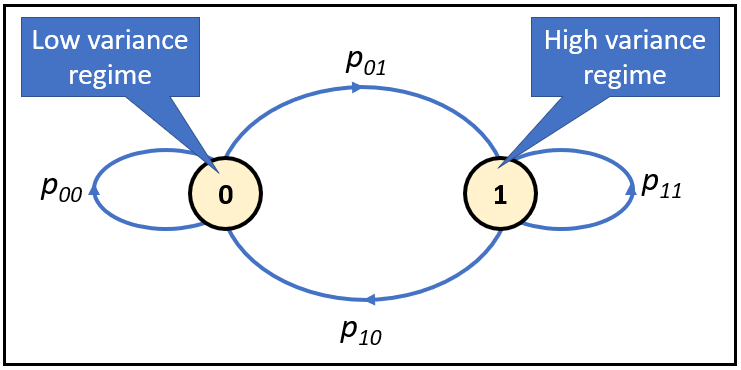
</div>

Our MSDR model equations is as follows:

<div>
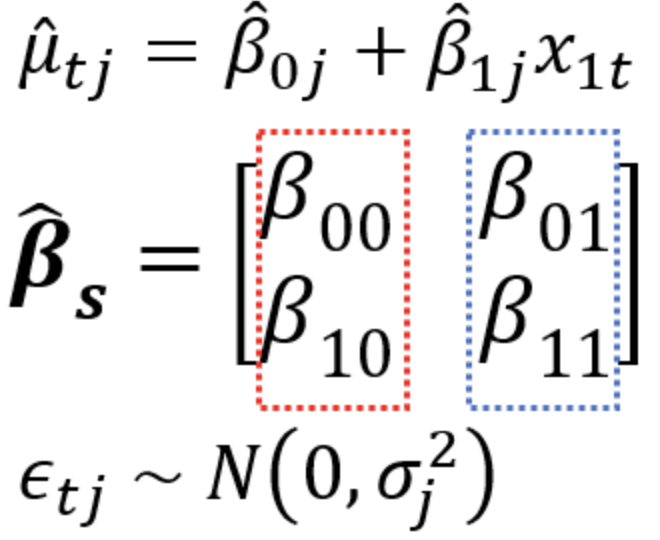
</div>

Notice that we have introduced **state-specific variance**. We are saying that the residual errors of the model are normally distributed around a zero mean and a variance that switches between two values depending on which state the underlying Markov process is in.

statsmodels supports a variance-switching MSDR model. Use **switching_variance=True**.

In [5]:
# Fit MSDR model using MarkovRegression
msdr_model = sm.tsa.MarkovRegression(endog=data['PCE_CHG'], k_regimes=2, trend='c', exog=data['UMCSENT_CHG'], switching_variance=True).fit(iter=1000)

# Print the summary statistics of the fitted model
print(msdr_model.summary())

                        Markov Switching Model Results                        
Dep. Variable:                PCE_CHG   No. Observations:                  525
Model:               MarkovRegression   Log Likelihood                2026.787
Date:                Tue, 16 Jan 2024   AIC                          -4037.575
Time:                        00:20:00   BIC                          -4003.468
Sample:                    01-01-1978   HQIC                         -4024.219
                         - 09-01-2021                                         
Covariance Type:               approx                                         
                             Regime 0 parameters                              
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0048      0.000     24.845      0.000       0.004       0.005
x1             0.0026      0.004      0.653      0.5

By looking at the fitted coefficients’ values in the results, we can write the regime-specific model equations as follows:

**For regime=0 (low-variance regime)**: </br>
PCE_CHG = 0.0048 + 0.0026*UMCSENT + ε_t, </br>
where ε_t ~ N(0, 1.701e-05)


**For regime=1 (high-variance regime)**: </br>
PCE_CHG = 0.0041 + 0.1203*UMCSENT + ε_t, </br>
where ε_t ~ N(0, 0.0012)

The Markov state transition diagram and matrix P are as follows:

<div>
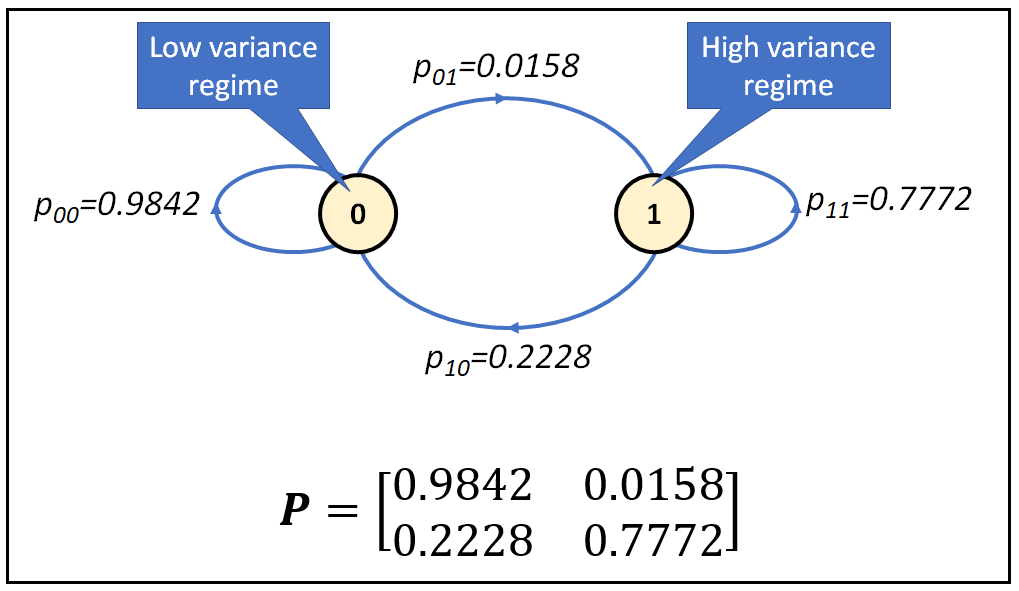
</div>

<h3> Plot Smoothed Probabilities of Regimes </h3>

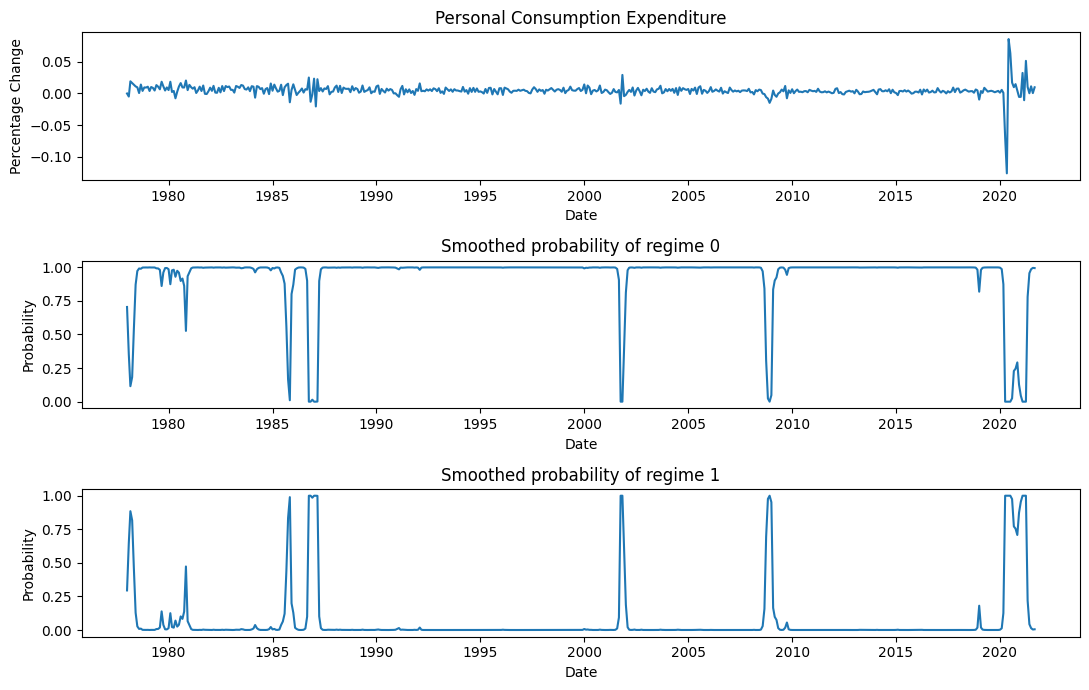

In [6]:
fig, axes = plt.subplots(3, 1, figsize=(11,7))

# Plot 'Personal Consumption Expenditure' 
axes[0].plot(data['PCE_CHG'])
axes[0].set_title('Personal Consumption Expenditure')
axes[0].set_xlabel('Date')
axes[0].set_ylabel('Percentage Change')

# Plot 'Smoothed probability of regime 0 at each time'
axes[1].plot(msdr_model.smoothed_marginal_probabilities[0])
axes[1].set_title('Smoothed probability of regime 0')
axes[1].set_xlabel('Date')
axes[1].set_ylabel('Probability')

# Plot 'Smoothed probability of regime 1 at each time'
axes[2].plot(msdr_model.smoothed_marginal_probabilities[1])
axes[2].set_title('Smoothed probability of regime 1')
axes[2].set_xlabel('Date')
axes[2].set_ylabel('Probability')

plt.tight_layout()
plt.show() 